<font face="Times New Roman">
<div dir=ltr align=center>
<font color=3C99D size=5>
    Variational Autoencoder (VAE)

In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torchvision import datasets, transforms 
from torch.utils.data import DataLoader 
import matplotlib.pyplot as plt 
import numpy as np
from torch.optim import Adam

torch.manual_seed(42)

The MNIST dataset is a large database of handwritten digits that is commonly used for training and testing various image processing and machine learning models. It contains 60,000 training images and 10,000 testing images of size (28, 28) and their corresponding labels from 0 to 9.

In [2]:
# Loading the MNIST dataset
data = datasets.MNIST('data', train=True, download=True,
                   transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 134350961.83it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 50833274.79it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 42283513.06it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 13997449.50it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



# Data Visualization

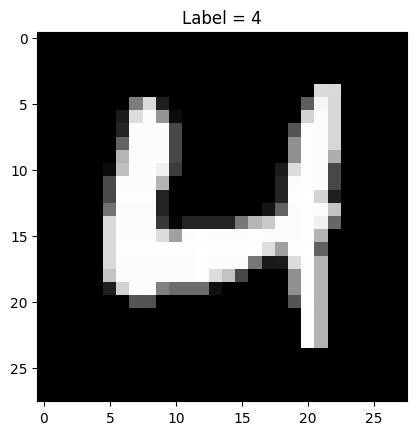

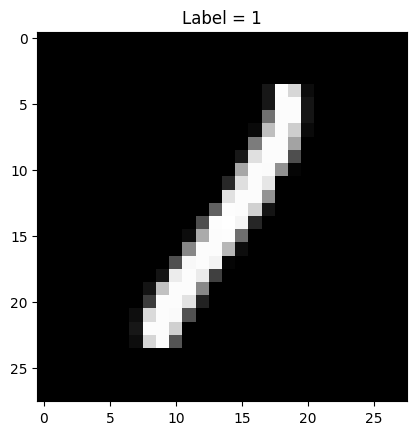

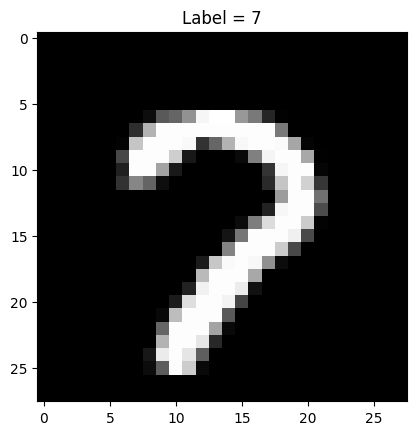

In [3]:
def imshow(data, shape = (28, 28)):
  plt.imshow(np.reshape(data[0], shape), cmap='gray')
  plt.title('Label = ' + str(data[1]))
  plt.show()

np.random.seed(0)
indecies = np.random.randint(0, len(data)-1, 3)

for i in indecies:
  imshow(data[i])

# Complete the following class to define the VAE structure.
This code defines a VAE class for a variational autoencoder (VAE) model, a generative model with an encoder-decoder based structure. The encoder compresses an input to a latent vector, which is drawn from a distribution learned by the encoder outputs. The decoder reconstructs the input from the latent vector, and the model optimizes the reconstruction quality and the difference between the latent distribution and a prior distribution. A VAE class usually specifies the encoder and decoder networks, the sampling layer, and the loss function.

In [4]:
class VAE(nn.Module):
    
    def __init__(self, hidden_size, latent_size):
        super(VAE, self).__init__()
        
        self.hidden_dim = hidden_size
        self.latent_dim = latent_size
        
        self.fc1 = nn.Linear(784, hidden_size)
        self.fc21 = nn.Linear(hidden_size, latent_size)
        self.fc22 = nn.Linear(hidden_size, latent_size)

        self.fc3 = nn.Linear(latent_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 784)

    def encode(self, x):        
        h = F.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h)
    
    
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu    
    
    
    def decode(self, z):
        h = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h))     
    
    
    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var


# Defining the Loss Function

In [5]:
def loss_function(recon_x, x, mu, logvar):
    bce_loss = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return bce_loss + kl_loss

# Training the Model

In [6]:
def train(model, optimizer, train_loader, device):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [10]:
batch_size = 512
train_loader = DataLoader(data, batch_size, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(512, 20).to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100

for epoch in range(1, epochs+1):
  train(model, optimizer, train_loader, device)

====> Epoch: 1 Average loss: 217.3319
====> Epoch: 2 Average loss: 150.3195
====> Epoch: 3 Average loss: 132.0999
====> Epoch: 4 Average loss: 123.5426
====> Epoch: 5 Average loss: 118.7326
====> Epoch: 6 Average loss: 115.6202
====> Epoch: 7 Average loss: 113.5197
====> Epoch: 8 Average loss: 112.0729
====> Epoch: 9 Average loss: 110.9852
====> Epoch: 10 Average loss: 110.1270
====> Epoch: 11 Average loss: 109.3115
====> Epoch: 12 Average loss: 108.6910
====> Epoch: 13 Average loss: 108.1589
====> Epoch: 14 Average loss: 107.6599
====> Epoch: 15 Average loss: 107.2754
====> Epoch: 16 Average loss: 106.9554
====> Epoch: 17 Average loss: 106.5622
====> Epoch: 18 Average loss: 106.3653
====> Epoch: 19 Average loss: 106.0980
====> Epoch: 20 Average loss: 105.9077
====> Epoch: 21 Average loss: 105.6366
====> Epoch: 22 Average loss: 105.3878
====> Epoch: 23 Average loss: 105.2516
====> Epoch: 24 Average loss: 105.1021
====> Epoch: 25 Average loss: 104.9039
====> Epoch: 26 Average loss: 104.

## Learning Rate
$0.0001=>Epoch:296\;Average\;loss:102.07510$ `too slow`

$0.001=>Epoch:58\;Average\;loss:102.0664$ `good`

$0.01=>trapped\;in\;Average\;Loss:105;106$ `no convergance`

# Image Generation

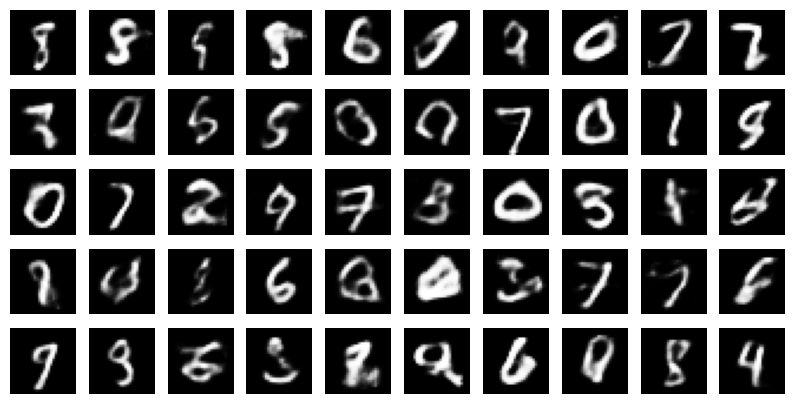

In [11]:
with torch.no_grad():
    z = torch.randn(batch_size, 20).to(device)
    sample = model.decode(z).cpu()
    
    fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(10,5))
    for i in range(5):
        for j in range(10):
            ax[i][j].imshow(sample[i*10+j].reshape(28, 28), cmap='gray')
            ax[i][j].axis('off')
    plt.show()

# Saving Model

In [14]:
torch.save(model.state_dict(), './vae_saved.pt')